# Disproving Einstein: Violating Local Realism

## Section 1: The Bell Test Demo
![](img/BellTest.png)

Using Qiskit to violate the CHSH inequality. We will run the experiment on one of IBM's real quantum computers

1. Python imports

In [1]:
import numpy as np  
from math import pi

from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.ibmq import least_busy

2. Extra import to help track jobs on ibmq by adding widget to top left

In [2]:
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

3. Actual code to prepare the necessary circuits
   
  In this example, the following measurement basis angles have been chosen to get the largest possible violation of the CHSH inequality:
  
   
   |Name         | Measurement |  Angle      |
   |:-----------:|:-----------:|:-----------:|
   |Alice        | Q           |      $0$     |
   |Alice        | R           | $-\frac{\pi}{2}$     |
   |Bob          | S           |    $-\frac{\pi}{4}$  |
   |Bob          | T           | $\frac{-3\pi}{4}$    |
    

In [3]:
def construct_circuit(cor_name, theta=pi/4):
    # make the bell pair
    circuit = QuantumCircuit(2, 2)
    circuit.h(0)
    circuit.cx(0,1)
    circuit.barrier()
    
    # perform the correct bell angle measurement based on cor_name (pair selected) 
    # 0 -> Alice and 1 -> Bob
    # Circuit.ry(theta, i) => rotation along y-axis by theta on qubit i
    if cor_name == 'QS':
        # Q -> circuit.ry(0)
        circuit.ry(-theta,1)          
    elif cor_name =='RS': 
        circuit.ry(-2*theta,0)
        circuit.ry(-theta,1)
    elif cor_name == 'QT':
        # Q -> circuit.ry(0)
        circuit.ry(-3*theta,1)
    elif cor_name == 'RT':
        circuit.ry(-2*theta,0)
        circuit.ry(-3*theta,1)
        
    circuit.barrier()
    # measure the circuit    
    circuit.measure([0,1],[0,1]) 
    return circuit

So for example, the 'RT' circuit looks like

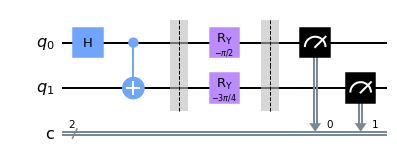

In [4]:
construct_circuit('RT').draw(output='mpl')

4. Setting up the IBM Quantum computers for upcoming simulations

In [5]:
provider = IBMQ.load_account() # load provider
# select backend or device to run on
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = least_busy(provider.backends(simulator=False))

#For scheduled jobs (won't work unless you have special access)
provider = IBMQ.providers(group='duke-uni-1')[0]
backend = provider.get_backend('ibmq_jakarta')


nshots = 8192 # set number of shots 

5. Write the code to run the pairings on actual quantum computer. 
   The code in the next block is used to run the various jobs on the quantum computers 

In [6]:
# Different pairs of measurements
cor_name_list = ['QS','RS','QT','RT']

E = {}
circs = []

# bundling up circuits so they run in parallel
for cor_name in cor_name_list:
    circs.append(construct_circuit(cor_name))
    
# Need to transpile the circuits first
circs = transpile(circs, backend=backend)

# Use Job Manager to batch the circuits into multiple jobs so the jobs can be submitted all at once
job_manager = IBMQJobManager()
print("running jobs ..")
results = job_manager.run(circs, backend=backend, shots=nshots).results()
print("jobs successful")

running jobs ..
jobs successful


In [7]:
for i in range(len(cor_name_list)):
    # runs to get statistical frequencies 
    counts = results.get_counts(i)
    print("counts of ", cor_name_list[i], " = ", counts)

counts of  QS  =  {'00': 3455, '01': 728, '10': 819, '11': 3190}
counts of  RS  =  {'00': 3460, '01': 690, '10': 1001, '11': 3041}
counts of  QT  =  {'00': 1016, '01': 3302, '10': 3241, '11': 633}
counts of  RT  =  {'00': 3640, '01': 683, '10': 852, '11': 3017}


We can see what some of these results look like:

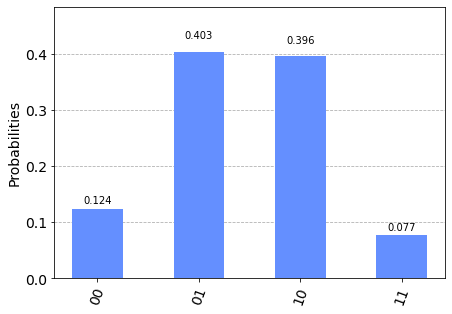

In [8]:
from qiskit.visualization import plot_histogram

plot_histogram(results.get_counts(2))

6. No we calculate the actual CHSH inequality

   For more details on the calculations used in the code below see https://en.wikipedia.org/wiki/CHSH_inequality

   The main idea:
   
   - The CHSH inequality states that, according to local realism,$ E(QS) + E(RS) + E(RT) - E(QT) ≤ 2$. 
   
   - By running a Bell Test, we can violate this inequality (and local realism)
   
   - For each measurement pair from ${Q,R,S,T}$, the number of coincidences is recorded for each category in
   ${\displaystyle \left\{N_{11},N_{00},N_{10},N_{01}\right\}}$, where $N_{a,b} =$ the number of times Alice measuered    a and Bob measure b. 
   
   - The experimental estimate for ${\displaystyle E}$ is then calculated as:
   ${\displaystyle E={\frac {N_{11}-N_{10}-N_{01}+N_{00}}{N_{total}}}}$
   which represents the average number of times the 2 measurements between Alice and Bob agree/disagree

In [9]:
for i, cor_name in enumerate(cor_name_list):
    # runs to get statistical frequencies 
    counts = results.get_counts(i)
    # Quantum correlations between Alice and Bob   
    E[cor_name] = counts.get('11', 0)/nshots\
        + counts.get('00', 0)/nshots\
        - counts.get('01', 0)/nshots\
        - counts.get('10', 0)/nshots
    
S = E['QS'] + E['RT'] + E['RS'] - E['QT']


print("Maximum value according to local realism =", 2.0, "\n")
print("Calculated S value = ", S)
print("(Ideal S value = ", np.sqrt(2)*2, ")")

Maximum value according to local realism = 2.0 

Calculated S value =  2.43212890625
(Ideal S value =  2.8284271247461903 )


## Section 2: Exercices

(a) Generate all Bell pairs 
    ![](img/BellStates.png)

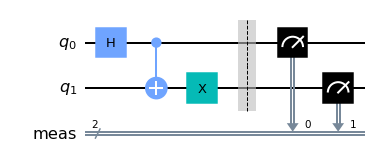

In [10]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)
qc.x(1)

qc.measure_all()
qc.draw(output='mpl')

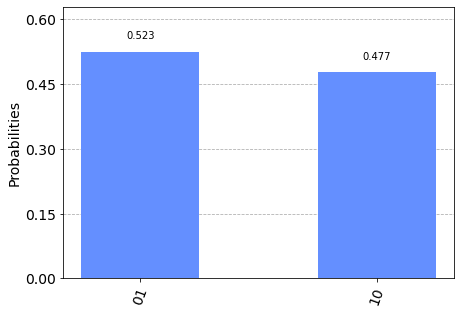

In [11]:
from qiskit import execute
backend = provider.get_backend('ibmq_qasm_simulator')
result = execute(qc, backend).result()
plot_histogram(result.get_counts())

(b) Can you create a 3-qubit entangled state? Verify either by measuring correlations or analytically showing the state is not seperable